# 《神经网络与深度学习》学习笔记
## 第4章 前馈神经网络

### 4.1 神经元
* 净输入：$ z = \mathbf{w}^{\mathrm{T}}\mathbf{x} + b$
* 激活函数：$f(*)$
  * 连续可导(允许少数点上不可导)的非线性函数。
  * 尽可能简单以提高计算效率。
  * 激活函数的导函数的值域需要在一个合适的区间内。
* 活性值：$a = f\left(z\right)$

#### 4.1.1 Sigmoid型激活函数
* Sigmoid型激活函数指的是一类S型曲线函数。
* Logistic函数：$\sigma(x)=\frac{1}{1+\exp (-x)}$
* Tanh函数：$\mathrm{tanh}\left(x\right)=\frac{\exp\left(x\right)-\exp\left(-x\right)}{\exp\left(x\right)+\exp\left(-x\right)}$
* $\mathrm{tanh}\left(x\right)=2\sigma(2x)-1$
* Hard-Logistic和Hard-Tanh函数：在一定区域内用一阶泰勒占来代替。

#### 4.1.2 修正单元
* $\mathrm{ReLU}(x) = \max(0, x)$
* $\mathrm{LeakyReLU}(x) = \max(x, \gamma x)$
* $\mathrm{PReLU}(x) = \max(0, x) + \gamma_{i}\min(0,x)$
* $\mathrm{ELU}(x) = \max(0, x) + \min\left(0, \gamma\left(\exp\left(x\right)-1\right)\right)$
* $\mathrm{Softplus}(x) = \log(1 + \exp(x))$

#### 4.1.3 Swish函数
* $\mathrm{swish}(x)=x\sigma(\beta x)$
* $\beta$为可学习的超参数，当$\sigma(\beta x)$接近1时，激活函数值接近$x$，当$\sigma(\beta x)$接近0时，激活函数的输出近似于0。

#### 4.1.4 高斯误差线性单元
* 利用正态分布的累计分布函数。

#### 4.1.5 Maxout单元
* $\mathrm{maxout}(x) = \max_{k\in[1,K]}(z_{k})$

### 4.2 网络结构
* 前馈网络、记忆网络、图网络

### 4.3 前馈神经网络
* 组成：输入层、隐藏层、输出层
* $\mathbf{z}^{(l)} = W^{(l)}\cdot\mathbf{a}^{(l-1)}+\mathbf{b}^{(l)}$
* $\mathbf{a}^{(l)}=f_l(\mathbf{z}^{(l)})$

#### 4.3.1 通用近似定理
* 常见的连续非线性函数都可以用前馈神经网络来近似。

#### 4.3.2 应用到机器学习
* 最后一层设置$C$个神经元，其激活函数为softmax函数，输出的值可以作为每个类的后验概率。

#### 4.3.3 参数学习
* 使用交叉熵损失函数，来迭代更新参数。
* 对每个参数进行求偏导比较低效，一般使用反向传播算法。

### 4.4 反向传播算法
* 前馈计算每一层的净输入$\mathbf{z}^{(l)}$和激活值$\mathbf{a}^{(l)}$，直到最后一层；
* 反向传播计算每一层的误差项$\delta^{(l)}$；
* 计算每一层参数的偏导数，并更新参数。

### 4.5 自动梯度计算
* 数值微分：利用数值方法来计算函数的导数。
* 符号微分：基于符号计算的自动求导方法。
* 自动微分：符号微分的程序。

### 4.6 优化问题
* 非凸优化问题
* 梯度小时问题

In [1]:
# 前馈神经网络Pytorch实现
# 代码参考自： https://github.com/L1aoXingyu/pytorch-beginner，有部分修改

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

batch_size = 64
learning_rate = 1e-2
num_epochs = 50
use_gpu = torch.cuda.is_available()

# 下载训练集 MNIST 手写数字训练集
train_dataset = datasets.MNIST(
    root='./datasets', train=True,
    transform=transforms.ToTensor(), download=True)

test_dataset = datasets.MNIST(
    root='./datasets', train=False,
    transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [2]:
# 定义简单的前馈神经网络
class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(NeuralNetwork, self).__init__()
        # 这是一个简单的前馈神经网络，有四层神经元组成，四层神经元中间共有三个连接。
        # 其中第一、二个连接是ReLU作为激活函数，这样子可以避免梯度消失。
        # 第三个连接用Softmax作为激活函数，这样子可以是输出的值代表每一个标签的概率。
        self.layer1 = nn.Sequential(
            nn.Linear(in_dim, n_hidden_1),
            nn.ReLU(True))
        self.layer2 = nn.Sequential(
            nn.Linear(n_hidden_1, n_hidden_2),
            nn.ReLU(True))
        self.layer3 = nn.Sequential(
            nn.Linear(n_hidden_2, out_dim),
            nn.LogSoftmax())

    def forward(self, x):
        output = self.layer3(self.layer2(self.layer1(x)))
        return output


In [3]:
# 模型及优化器构造
model = NeuralNetwork(28 * 28, 20, 20, 10).cuda if use_gpu else NeuralNetwork(28 * 28, 20, 20, 10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [4]:
# 训练过程
for epoch in range(num_epochs):
    print('*' * 10)
    print(f'epoch {epoch+1}')
    running_loss, running_acc = .0, .0
    for i, data in enumerate(train_loader, 1):
        img, label = data
        img = img.view(img.size(0), -1)
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        # 向前传播
        out = model(img)
        loss = criterion(out, label)
        running_loss += loss.item()
        _, pred = torch.max(out, 1)
        running_acc += (pred == label).float().mean()
        # 向后传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 300 == 0:
            print(f'[{epoch+1}/{num_epochs}] Loss: {running_loss/i:.6f}, Acc: {running_acc/i:.6f}')
    print(f'Finish {epoch+1} epoch, Loss: {running_loss/i:.6f}, Acc: {running_acc/i:.6f}')
    model.eval()
    eval_loss, eval_acc = .0, .0
    for data in test_loader:
        img, label = data
        img = img.view(img.size(0), -1)
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        with torch.no_grad():
            out = model(img)
            loss = criterion(out, label)
        eval_loss += loss.item()
        _, pred = torch.max(out, 1)
        eval_acc += (pred == label).float().mean()
    print(f'Test Loss: {eval_loss/len(test_loader):.6f}, Acc: {eval_acc/len(test_loader):.6f}\n')

# 保存模型
torch.save(model.state_dict(), './neural_network.pth')

**********
epoch 1
C:\Users\TZX\Anaconda2\envs\py3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
[1/50] Loss: 2.271235, Acc: 0.170312
[1/50] Loss: 2.151601, Acc: 0.312578
[1/50] Loss: 1.923667, Acc: 0.395851
Finish 1 epoch, Loss: 1.892439, Acc: 0.406333
Test Loss: 1.093001, Acc: 0.675955

**********
epoch 2
[2/50] Loss: 0.935246, Acc: 0.717604
[2/50] Loss: 0.827743, Acc: 0.751745
[2/50] Loss: 0.750954, Acc: 0.775972
Finish 2 epoch, Loss: 0.742436, Acc: 0.778685
Test Loss: 0.535461, Acc: 0.839968

**********
epoch 3
[3/50] Loss: 0.522936, Acc: 0.847031
[3/50] Loss: 0.504862, Acc: 0.851302
[3/50] Loss: 0.490059, Acc: 0.855764
Finish 3 epoch, Loss: 0.488221, Acc: 0.856710
Test Loss: 0.425017, Acc: 0.873806

**********
epoch 4
[4/50] Loss: 0.423469, Acc: 0.876354
[4/50] Loss: 0.420817, Acc: 0.877500
[4/50] Loss: 0.415847, Acc: 0.879861


C:\Users\TZX\Anaconda2\envs\py3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


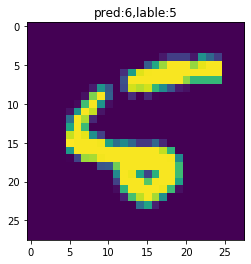

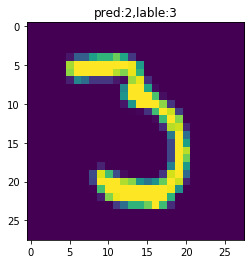

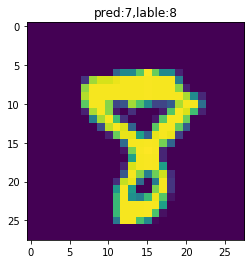

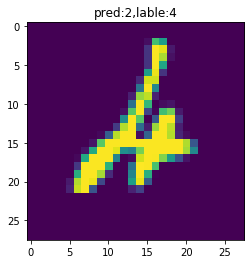

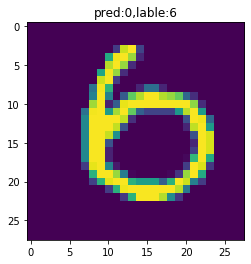

In [5]:
# 输出数据可视化
from PIL import Image
import matplotlib.pyplot as plt

sample_n = 5
n = 0

for data in test_loader:
    img, label = data
    images = (img*256).int()
    img = img.view(img.size(0), -1)
    if use_gpu:
        img = img.cuda()
        label = label.cuda()
    with torch.no_grad():
        out = model(img)
    _, pred = torch.max(out, 1)
    for i in range(len(pred)):
        if pred[i] != label[i]:
            plt.figure()
            plt.title('pred:{},lable:{}'.format(int(pred[i]), int(label[i])))
            plt.imshow(images[i][0])
            n += 1
        if(n >= sample_n):
            break
    if(n >= sample_n):
        break